In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

plt.style.use('dark_background')

In [35]:
# Load CSV file
tcs = pd.read_csv("TCS.csv")
tcs.shape

(4139, 15)

In [36]:
tcs.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [37]:
# Convert 'Date' to datetime
tcs['Date'] = pd.to_datetime(tcs['Date'])

# Filter between Jan 2008 and Dec 2020
mask = (tcs['Date'] >= '2008-01-01') & (tcs['Date'] <= '2020-12-31')

tcs_filtered = tcs.loc[mask]

In [38]:
# Select required columns
tcs = tcs_filtered[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [39]:
tcs

,Date,Open,High,Low,Close,Volume
840,2008-01-01,1077.00,1077.00,1052.00,1054.55,232097
841,2008-01-02,1060.00,1061.00,1031.50,1050.00,716231
842,2008-01-03,1030.10,1045.00,1005.35,1011.05,1292070
843,2008-01-04,1011.05,1022.90,1002.30,1005.20,579717
844,2008-01-07,1000.00,1008.80,972.50,975.60,911836
...,...,...,...,...,...,...
4054,2020-12-24,2909.00,2921.35,2883.20,2909.35,1807144
4055,2020-12-28,2910.00,2949.70,2902.00,2929.40,2108994
4056,2020-12-29,2920.00,2952.00,2920.00,2930.50,1994151
4057,2020-12-30,2934.40,2947.70,2902.00,2909.30,2637968


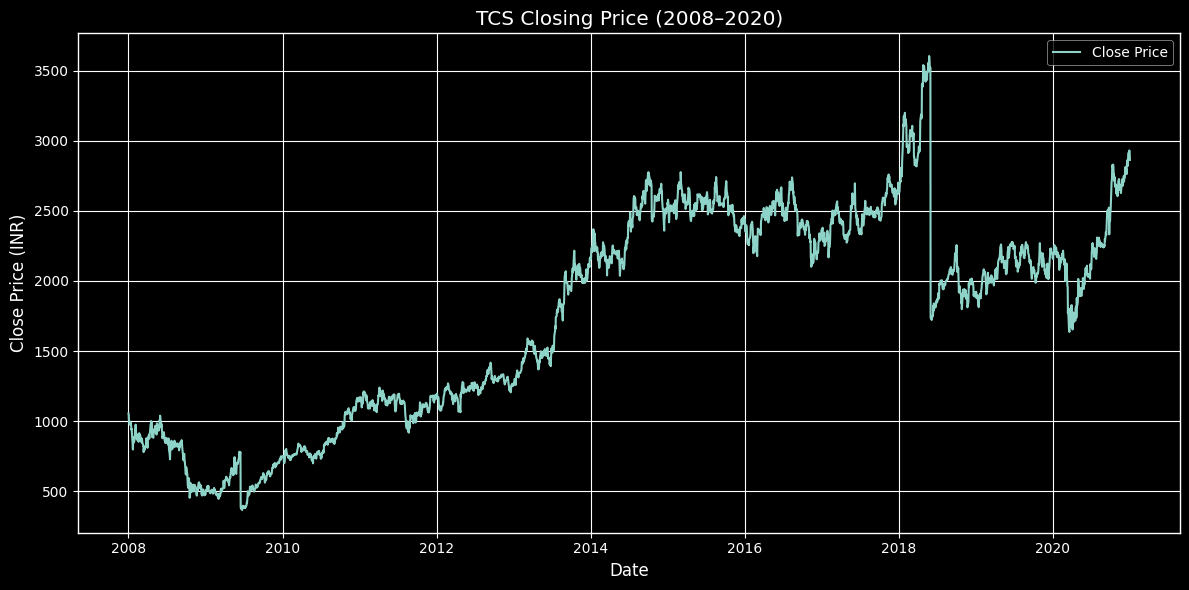

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(tcs['Date'], tcs['Close'], label='Close Price')
plt.title("TCS Closing Price (2008–2020)")
plt.xlabel("Date")
plt.ylabel("Close Price (INR)")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# Create next 5 days’ close price as separate columns
for i in range(1, 6):
    tcs[f'close_t+{i}'] = tcs['Close'].shift(-i)

# Drop rows with NaN values (last 5)
tcs_model = tcs.dropna().copy()

In [42]:
tcs_model

,Date,Open,High,Low,Close,Volume,close_t+1,close_t+2,close_t+3,close_t+4,close_t+5
840,2008-01-01,1077.00,1077.00,1052.00,1054.55,232097,1050.00,1011.05,1005.20,975.60,987.85
841,2008-01-02,1060.00,1061.00,1031.50,1050.00,716231,1011.05,1005.20,975.60,987.85,996.30
842,2008-01-03,1030.10,1045.00,1005.35,1011.05,1292070,1005.20,975.60,987.85,996.30,981.65
843,2008-01-04,1011.05,1022.90,1002.30,1005.20,579717,975.60,987.85,996.30,981.65,989.75
844,2008-01-07,1000.00,1008.80,972.50,975.60,911836,987.85,996.30,981.65,989.75,961.15
...,...,...,...,...,...,...,...,...,...,...,...
4049,2020-12-17,2811.00,2853.70,2805.00,2838.20,2863460,2861.00,2820.15,2872.50,2908.75,2909.35
4050,2020-12-18,2868.00,2898.00,2846.20,2861.00,6076692,2820.15,2872.50,2908.75,2909.35,2929.40
4051,2020-12-21,2861.00,2886.50,2785.00,2820.15,2705195,2872.50,2908.75,2909.35,2929.40,2930.50
4052,2020-12-22,2834.00,2883.65,2818.65,2872.50,2881737,2908.75,2909.35,2929.40,2930.50,2909.30


In [43]:
# Features: today's market indicators
X = tcs_model[['Open', 'High', 'Low', 'Close', 'Volume']]

# Targets: close prices for next 5 days
y = tcs_model[['close_t+1', 'close_t+2', 'close_t+3', 'close_t+4', 'close_t+5']]

In [48]:
# Time series split: no shuffling
total = len(X)

train_size = int(0.7 * total)
val_size = int(0.15 * total)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

print(f"Train size: {len(X_train)}, \nValidation size: {len(X_val)}, \nTest size: {len(X_test)}")

Train size: 2249, 
Validation size: 482, 
Test size: 483


In [49]:
# Initialize and train Random Forest with MultiOutput
model = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, random_state=42)
)

In [50]:
# Model training
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [51]:
# Validation set evaluation
val_pred = model.predict(X_val)
print("📊 Validation Set Performance:")
for i in range(5):
    mse = mean_squared_error(y_val.iloc[:, i], val_pred[:, i])
    r2 = r2_score(y_val.iloc[:, i], val_pred[:, i])
    print(f"Day +{i+1} - MSE: {mse:.2f}, R²: {r2:.4f}")

📊 Validation Set Performance:
Day +1 - MSE: 48900.05, R²: 0.7501
Day +2 - MSE: 58971.49, R²: 0.6995
Day +3 - MSE: 64248.59, R²: 0.6736
Day +4 - MSE: 68484.59, R²: 0.6530
Day +5 - MSE: 69600.78, R²: 0.6483


In [52]:
# Test set evaluation
test_pred = model.predict(X_test)
print("\n📊 Test Set Performance:")
for i in range(5):
    mse = mean_squared_error(y_test.iloc[:, i], test_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], test_pred[:, i])
    print(f"Day +{i+1} - MSE: {mse:.2f}, R²: {r2:.4f}")


📊 Test Set Performance:
Day +1 - MSE: 2709.78, R²: 0.9566
Day +2 - MSE: 4774.90, R²: 0.9246
Day +3 - MSE: 6521.09, R²: 0.8986
Day +4 - MSE: 8083.13, R²: 0.8760
Day +5 - MSE: 9436.92, R²: 0.8569


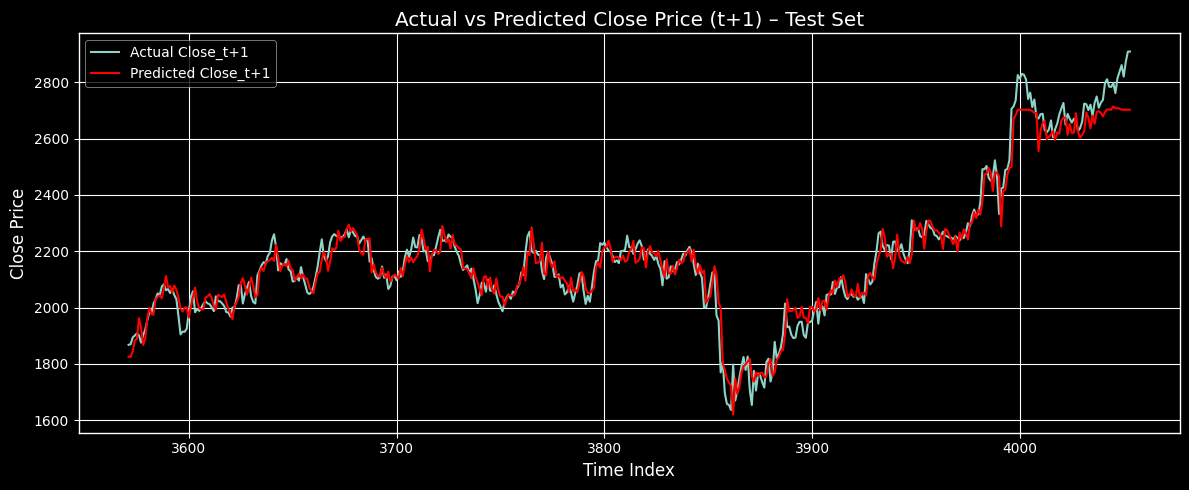

In [56]:
# Visualize Prediction vs Actual (Test Set)
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test['close_t+1'], label="Actual Close_t+1")
plt.plot(y_test.index, test_pred[:, 0], label="Predicted Close_t+1" , color = "red")
plt.title("Actual vs Predicted Close Price (t+1) – Test Set")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Hyper Parameter Tuning (Bayesian)

In [57]:
!pip install scikit-optimize


   ---------------------------------------- 0/2 [pyaml]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   -------------------- ------------------- 1/2 [scikit-optimize]
   ---------------------------------------- 2/2 [scikit-optimize]



In [58]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import TimeSeriesSplit

In [61]:
# Define hyperparameter space
param_space = {
    'estimator__n_estimators': Integer(50, 300),
    'estimator__max_depth': Integer(5, 30),
    'estimator__min_samples_split': Integer(2, 10),
    'estimator__min_samples_leaf': Integer(1, 5),
    'estimator__max_features': Real(0.5, 1.0, prior='uniform')
}

In [62]:
# Prepare Model & Cross-Validator

# MultiOutputRegressor wrapper
base_rf = RandomForestRegressor(random_state=42)
multi_rf = MultiOutputRegressor(base_rf)

# TimeSeriesSplit for time series validation
tscv = TimeSeriesSplit(n_splits=3)

In [63]:
# Setup Bayesian Search
opt = BayesSearchCV(
    estimator=multi_rf,
    search_spaces=param_space,
    cv=tscv,
    n_iter=25,  # Number of iterations
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [65]:
# Run search on training + validation (combined for better generalization)
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

print(X_tune.shape , y_tune.shape)

(2731, 5) (2731, 5)


In [66]:
# Run Bayesian Search
opt.fit(X_tune, y_tune)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42)),
              n_iter=25, n_jobs=-1, random_state=42, scoring='r2',
              search_spaces={'estimator__max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'estimator__max_features': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'estimator__min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'estimator__min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'estimator__n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize')},
              verbose=2)

In [67]:
# Print the best parameters
print("Best Parameters:" , opt.best_params_)

Best Parameters: OrderedDict({'estimator__max_depth': 28, 'estimator__max_features': 0.5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300})


In [68]:
# Re-train best model on full training + validation data
best_model = opt.best_estimator_

In [69]:
# Predict on test set
y_test_pred = best_model.predict(X_test)

In [70]:
# Performance metrics after tuning
print("\n Test Set Performance After Bayesian Tuning:")
for i in range(5):
    mse = mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    print(f"Day +{i+1} - MSE: {mse:.2f}, R²: {r2:.4f}")


 Test Set Performance After Bayesian Tuning:
Day +1 - MSE: 1810.14, R²: 0.9710
Day +2 - MSE: 3429.06, R²: 0.9459
Day +3 - MSE: 5127.43, R²: 0.9202
Day +4 - MSE: 6875.86, R²: 0.8945
Day +5 - MSE: 8317.46, R²: 0.8739


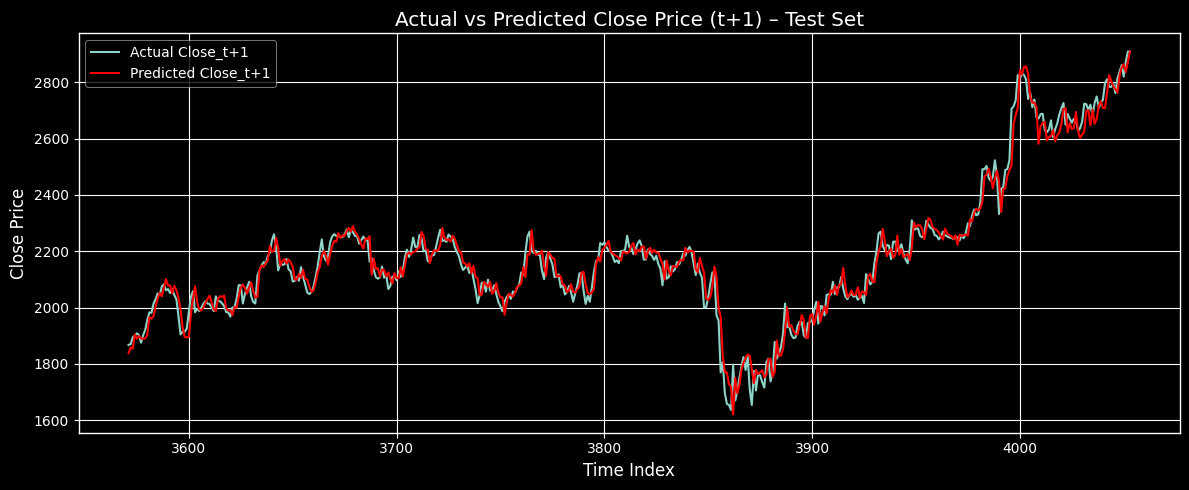

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test['close_t+1'], label="Actual Close_t+1")
plt.plot(y_test.index, y_test_pred[:, 0], label="Predicted Close_t+1", color = "red")
plt.title("Actual vs Predicted Close Price (t+1) – Test Set")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
# Saving the best model
import pickle

# Save the model
with open('multioutput model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# # Load the model
# with open('model.pkl', 'rb') as file:
#     model = pickle.load(file)